In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
from pathlib import Path
import yaml
import logging
import uuid
from importlib import import_module


try:
    from .exceptions import PluginError, ImageError, PluginTimeoutError, FileError, ConfigurationError
    from .base_plugin import BasePlugin
except ImportError:
    # support jupyter developement
    from exceptions import PluginError, ImageError, PluginTimeoutError, FileError, ConfigurationError
    from base_plugin import BasePlugin

In [44]:
logger = logging.getLogger(__name__)

In [45]:
import logging
import sys

# Configure logging to show in Jupyter Notebook
def setup_notebook_logging(level=logging.DEBUG):
    log_format = '%(asctime)s [%(levelname)s] [%(name)s] - %(message)s'
    
    # Clear any existing handlers to prevent duplicate logging
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    # Set up logging for notebook
    logging.basicConfig(
        level=level,
        format=log_format,
        handlers=[logging.StreamHandler(sys.stdout)]
    )
    
    logging.getLogger(__name__).info("Notebook logging configured.")

# Run this cell to enable logging
setup_notebook_logging()

2024-12-29 18:05:13,569 [INFO] [__main__] - Notebook logging configured.


In [106]:
import yaml
from pathlib import Path
import logging


class PluginManager:
    def __init__(
        self,
        config: dict = None,
        plugin_path: Path = None,
        config_path: Path = None,
        main_schema_file: str = None,
        plugin_schema_file: str = None,
    ):
        self._config = {}
        self._configured_plugins = []        
        self.plugin_path = plugin_path
        self.config_path = config_path
        self.main_schema_file = main_schema_file
        self.plugin_schema_file = plugin_schema_file
        self._main_schema = None
        self._plugin_schema = None

        # Initialize config if provided
        if config:
            self.config = config

        logger.debug("PluginManager initialized with default values.")

    @property
    def config(self):
        return self._config

    @config.setter
    def config(self, value):
        if not isinstance(value, dict):
            raise TypeError("Config must be a dictionary.")
        
        schema = self.main_schema
        if schema:
            logger.info("Validating config against main schema...")
            self._validate_config(value, schema)

        self._config = value
        logger.info("Configuration successfully updated.")

    @property
    def config_path(self):
        return self._config_path

    @config_path.setter
    def config_path(self, value):
        if not value:
            logger.warning("Config path set to None. Schema loading disabled.")
            self._config_path = None
            return

        if not isinstance(value, Path):
            value = Path(value)

        if not value.is_dir():
            raise FileNotFoundError(f"Config directory not found at {value}")

        self._config_path = value
        self._main_schema = None
        self._plugin_schema = None
        logger.info(f"Config path set to {self._config_path}")

    @property
    def plugin_path(self):
        return self._plugin_path

    @plugin_path.setter
    def plugin_path(self, value):
        if not value:
            logger.warning("Plugin path set to None.")
            self._config_path = None
            return

        if not isinstance(value, Path):
            value = Path(value)

        if not value.is_dir():
            raise FileNotFoundError(f"Plugin directory not found at {value}")

        self._plugin_path = value
        logger.info(f"Plugin path set to {self._plugin_path}")
    
    @property
    def main_schema(self):
        if self._main_schema is None:
            if not self._config_path or not self.main_schema_file:
                logger.warning("Config path or main schema file not set.")
                return {}

            schema_file = self._config_path / self.main_schema_file
            if not schema_file.is_file():
                raise FileNotFoundError(f"Main schema file not found at {schema_file}")

            logger.info(f"Loading main config schema from {schema_file}")
            with open(schema_file, "r") as f:
                self._main_schema = yaml.safe_load(f)
        return self._main_schema

    @property
    def plugin_schema(self):
        if self._plugin_schema is None:
            if not self._config_path or not self.plugin_schema_file:
                logger.warning("Config path or plugin schema file not set.")
                return {}

            schema_file = self._config_path / self.plugin_schema_file
            if not schema_file.is_file():
                raise FileNotFoundError(f"Plugin schema file not found at {schema_file}")

            logger.info(f"Loading plugin schema from {schema_file}")
            with open(schema_file, "r") as f:
                self._plugin_schema = yaml.safe_load(f)
        return self._plugin_schema

    @property
    def configured_plugins(self):
        return self._configured_plugins

    @configured_plugins.setter
    def configured_plugins(self, value):
        if not isinstance(value, list):
            raise TypeError("configured_plugins must be a list of plugin configurations.")

        for plugin_entry in value:
            if not isinstance(plugin_entry, dict) or 'plugin' not in plugin_entry or 'base_config' not in plugin_entry:
                raise ValueError("Each entry in configured_plugins must be a dict with 'plugin' and 'config' keys.")

            
            # Always assign a new UUID (overwriting existing one)
            plugin_uuid = str(uuid.uuid4())[:8]
            plugin_entry['base_config']['uuid'] = plugin_uuid
            logger.info(f"Assigned UUID {plugin_entry['base_config']['uuid']} to plugin {plugin_entry['plugin']}.")
            
            # Validate the config against the plugin schema
            schema = self.plugin_schema.get('plugin_config', {})
            self._validate_config(plugin_entry['base_config'], schema)

            # final setup and validation
            if not plugin_entry.get('base_config', {}).get('name', None):
                name = plugin_entry.get('plugin') + '-' + plugin_uuid
                logger.info(f'No human readable plugin name set. Using: {name}')
                plugin_entry['base_config']['name'] = plugin_entry.get('plugin')
        
        self._configured_plugins = value
        logger.info("configured_plugins successfully validated and set.")
    
    def reload_schemas(self):
        """
        Force reload of main and plugin schemas.
        """
        self._main_schema = None
        self._plugin_schema = None
        logger.info("Schemas reloaded.")

    def _validate_config(self, config, schema):
        """
        Validate configuration against a schema.
        
        Args:
            config (dict): Configuration to validate.
            schema (dict): Schema to validate against.

        Raises:
            ValueError: If the config does not match the schema.
        """
        errors = []
        
        for key, params in schema.items():
            description = params.get('description', 'No description available')
            if key not in config:
                if params.get('required', False):
                    errors.append(f"{key} is required but missing. Description: {description}")
                else:
                    config[key] = params.get('default')
            else:
                value = config[key]
                expected_type = eval(params['type'])

                # Type check
                if not isinstance(value, expected_type):
                    errors.append(f"{key} must be of type {expected_type.__name__} (got {type(value).__name__}). Description: {description}")

                # Allowed values check
                allowed = params.get('allowed')
                if allowed and value not in allowed:
                    errors.append(f"{key} must be one of {allowed} (got {value}). Description: {description}")

        if errors:
            raise ValueError("Config validation failed:\n" + "\n".join(errors))

        logger.info("Config passed schema validation.")

    def load_plugins(self):
        """
        Locate and load plugins based on the configured_plugins property.
        """
        self.active_plugins = []
        self.dormant_plugins = []
    
        for entry in self.configured_plugins:
            plugin_name = entry['plugin']
            base_config = entry['base_config']
            plugin_params = entry.get('plugin_params', {})  # Defaults to empty if missing
    
            try:
                # Import the plugin module dynamically as part of the plugins package
                module = import_module(f'plugins.{plugin_name}')
    
                # Attach the update function from the module
                if hasattr(module.plugin, 'update_function'):
                    base_config['update_function'] = module.plugin.update_function
                else:
                    logger.warning(f"{plugin_name}: update_function not found. Skipping plugin.")
                    continue
    
                # Load layout (if specified) from the plugin module
                if 'layout' in base_config:
                    layout_name = base_config['layout']
                    if hasattr(module.layout, layout_name):
                        layout = getattr(module.layout, layout_name)
                        base_config['layout'] = layout
                    else:
                        raise AttributeError(f"Layout '{layout_name}' not found in {plugin_name}")
                else:
                    logger.warning(f"{plugin_name} is missing a configured layout. Skipping plugin.")
                    continue
    
                # Instantiate BasePlugin with **base_config and pass plugin_params to config
                plugin_instance = BasePlugin(
                    **base_config,
                    config=plugin_params,  # Pass plugin_params as config
                )
    
                plugin_instance.update_function = base_config['update_function']
    
                # Sort into active or dormant
                if base_config.get('dormant', False):
                    self.dormant_plugins.append(plugin_instance)
                    logger.info(f"Loaded dormant plugin: {plugin_name}")
                else:
                    self.active_plugins.append(plugin_instance)
                    logger.info(f"Loaded active plugin: {plugin_name}")
    
            except ModuleNotFoundError as e:
                logger.warning(f"Error: {e} while loading {plugin_name}. Skipping plugin.")
                continue
            except AttributeError as e:
                logger.warning(f"{e}. Skipping plugin: {plugin_name}")
                continue
            except KeyError:
                logger.info(f"{plugin_name}: No module specified, skipping.")
                continue
            except Exception as e:
                logger.error(f"{plugin_name} failed to load due to error: {e}. Skipping plugin.")
                continue
    
        logger.info(f"Loaded {len(self.active_plugins)} active plugins and {len(self.dormant_plugins)} dormant plugins.")

In [101]:
! ln -s ../plugins ./

ln: failed to create symbolic link './plugins': File exists


In [126]:
m = PluginManager()

m.plugin_path = './plugins/'
m.config_path = '../config/'
m.main_schema_file = 'main_schema.yaml'
m.plugin_schema_file = 'plugin_schema.yaml'

config = {
    'screen_mode': 'L',
    'resolution': (160, 190),
}

configured_plugins = [
    {'plugin': 'basic_clock',
         'base_config': {
            'name': 'Basic Clock',
            'duration': 100,
            'refresh_interval': 60,
            'dormant': False,
            'layout': 'layout',
         }
    },
    {'plugin': 'word_clock',
        'base_config':{
            'name': 'Word Clock',
            'duration': 130,
            'refresh_interval': 60,
            'layout': 'layout',
        },
        'plugin_params': {
            'foo': 'bar',
            'spam': 7,
            'username': 'Monty'}
    },
    {'plugin': 'xkcd_comic',
        'base_config': {
            'name': 'XKCD',
            'duration': 200,
            'refresh_interval': 1800,
            'dormant': False,
            'layout': 'layout'
        },
        'plugin_params':{
            'max_x': 800,
            'max_y': 600,
            'resize': False,
            'max_retries': 5
        }
             
    }
]
m.config = config
m.configured_plugins = configured_plugins

m.configured_plugins

m.load_plugins()

2024-12-29 20:17:31,488 [WARNING] [__main__] - Plugin path set to None.
2024-12-29 20:17:31,489 [WARNING] [__main__] - Config path set to None. Schema loading disabled.
2024-12-29 20:17:31,491 [DEBUG] [__main__] - PluginManager initialized with default values.
2024-12-29 20:17:31,493 [INFO] [__main__] - Plugin path set to plugins
2024-12-29 20:17:31,496 [INFO] [__main__] - Config path set to ../config
2024-12-29 20:17:31,499 [INFO] [__main__] - Loading main config schema from ../config/main_schema.yaml
2024-12-29 20:17:31,509 [INFO] [__main__] - Validating config against main schema...
2024-12-29 20:17:31,511 [INFO] [__main__] - Config passed schema validation.
2024-12-29 20:17:31,514 [INFO] [__main__] - Configuration successfully updated.
2024-12-29 20:17:31,516 [INFO] [__main__] - Assigned UUID 0706d660 to plugin basic_clock.
2024-12-29 20:17:31,517 [INFO] [__main__] - Loading plugin schema from ../config/plugin_schema.yaml
2024-12-29 20:17:31,529 [INFO] [__main__] - Config passed sc

2024-12-29 20:17:53,943 [INFO] [base_plugin] - XKCD - Running update (force=False)...
2024-12-29 20:17:53,953 [DEBUG] [urllib3.connectionpool] - Starting new HTTPS connection (1): xkcd.com:443
2024-12-29 20:17:53,993 [DEBUG] [urllib3.connectionpool] - https://xkcd.com:443 "GET /info.0.json HTTP/1.1" 200 255
2024-12-29 20:17:53,998 [INFO] [plugins.xkcd_comic.plugin] - Randomly selecting comic from 5 total comics.
2024-12-29 20:17:54,004 [DEBUG] [urllib3.connectionpool] - Starting new HTTPS connection (1): xkcd.com:443
2024-12-29 20:17:54,058 [DEBUG] [urllib3.connectionpool] - https://xkcd.com:443 "GET /62/info.0.json HTTP/1.1" 200 385
2024-12-29 20:17:54,063 [INFO] [base_plugin] - XKCD - Downloading image from https://imgs.xkcd.com/comics/karnaugh.jpg
2024-12-29 20:17:54,070 [DEBUG] [urllib3.connectionpool] - Starting new HTTPS connection (1): imgs.xkcd.com:443
2024-12-29 20:17:54,132 [DEBUG] [urllib3.connectionpool] - https://imgs.xkcd.com:443 "GET /comics/karnaugh.jpg HTTP/1.1" 200 69

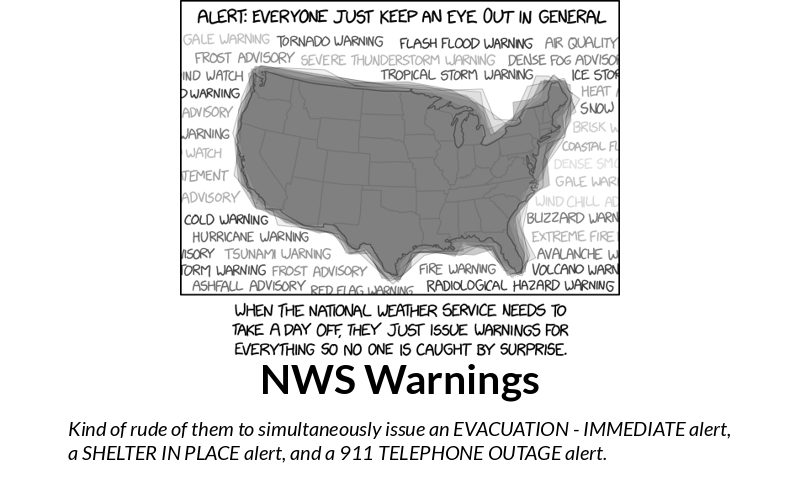

In [127]:
m.active_plugins[2].update()

m.active_plugins[2].image